1. Nama: Muhammad Zukri Al Walidani
2. Batch: 007
3. Phase:2

Dunia industri membutuhkan efisiensi dalam produksinya, termasuk dunia industri pertanian. Tidak jarang perusahaan harus mengeluarkan biaya tenaga kerja karena kurangnya automatisasi dan tidak jarang pula terjadi human error pada tahap produksi. Salah satunya tahap penyortiran atau grading yang merupakan bagian penting dalam menjaga kualitas bahan baku agar produk yang dihasilkan tetap terjaga kualitasnya dan lebih tahan lama. Diantara produk yang membutuhkan penyortiran seperti buah-buahan. Berikut merupakan dataset buah-buahan terdiri dari buah pisang, jeruk dan apel. Terdapat buah busuk yang tergabung diantara buah-buah yang segar oleh karena itu dibutuhkan sebuah solusi untuk memisahkan atau menyortir buah yang segar dan buah yang busuk melalui sistem automatis untuk membantu perusahaan mengefisiensikan biaya dan menjaga kualitas produksinya.

Import Pustaka

Data Loading

In [82]:
#mengkoneksikan dengan google drive tempat meletakkan data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [83]:
#masuk ke folder dataset
% cd /content/gdrive/My Drive/dataset2

/content/gdrive/My Drive/dataset2


In [84]:
#membuktikan lokasi berada di folder yang benar
! ls

dataset_buah  models


In [85]:
#membuktikan lokasi berada di folder yang benar
! pwd

/content/gdrive/My Drive/dataset2


Eksplorasi Data

In [86]:
#memeriksa item yang ada dalam masing masing folder
import os

for dirpath, dirnames, filenames in os.walk('dataset_buah'):
  print(f"Ada {len(dirnames)} folder dan ada {len(filenames)} gambar di dalam {dirpath}")

Ada 2 folder dan ada 0 gambar di dalam dataset_buah
Ada 2 folder dan ada 0 gambar di dalam dataset_buah/train
Ada 0 folder dan ada 1680 gambar di dalam dataset_buah/train/freshapples
Ada 0 folder dan ada 2340 gambar di dalam dataset_buah/train/rottenapples
Ada 2 folder dan ada 0 gambar di dalam dataset_buah/test
Ada 0 folder dan ada 395 gambar di dalam dataset_buah/test/freshapples
Ada 0 folder dan ada 601 gambar di dalam dataset_buah/test/rottenapples


In [87]:
#melihat label pada data train
import pathlib
import numpy as np
data_dir = pathlib.Path('dataset_buah/train')
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['freshapples' 'rottenapples']


Exploratory Data Analysis

In [88]:
#melihat label pada data test
import pathlib
import numpy as np
data_dir = pathlib.Path('dataset_buah/test')
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['freshapples' 'rottenapples']


In [89]:
# mmembuat fungsi untuk melihat data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 3)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

Image Shape : (408, 366, 3)


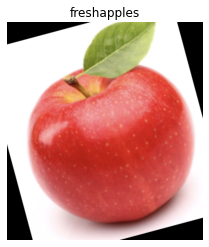

In [90]:
#melihat data random pada folder freshapples
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='freshapples')

Image Shape : (446, 394, 4)


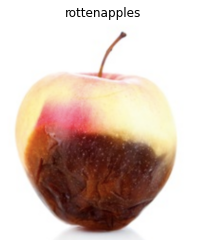

In [91]:
#melihat data random pada folder rottenapples
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='rottenapples')

Insight:
1. data terdiri dari 3 jenis buah buahan yaitu jeruk, apel dan pisang.
2. Buah buahan terdiri dari dua klasifikasi yaitu buah yang busuk dan buah yang segar
3. Sudut pengambilan gambar diambil dari berbagai angle (bawah, atas, samping, miring,dan sudut lain) hal ini dimaksudkan untuk menambah variasi pengetahuan model, semakin banyak variasi maka model akan semakin fleksibel dalam memprediksi data baru nantinya. 
4. variasi juga dilakukan pada buah yang memiliki dua jenis warna seperti apel dan jeruk. terlihat bahwa pada gambar jeruk ada yang berwarna hijau dan bewarna orange. begitu pula dengan buah lainya.

Data Preprocessing

In [108]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(46)

# preprocessing berupa scaling image
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)


# membuat data dengan berbagai arah untuk memberikan pengetahuan lebih untuk model
train_datagen_augmented = ImageDataGenerator(rescale=1/255.0,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)
#membuat dictonary
train_dir = 'dataset_buah/train/'
test_dir = 'dataset_buah/test/'

# pembuatan pipeline
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=50,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                               batch_size=50,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=50,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)

Found 4020 images belonging to 2 classes.
Found 4020 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


Model Definition and Model Evaluation

In [109]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [113]:
#pembuatan arsitektur base model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential([
                    Conv2D(16, 3, activation='relu', input_shape=[200, 200, 3]),
                    Dropout(0.2),
                    MaxPool2D(2),
                    Conv2D(64, 3, activation='relu'),
                    Dropout(0.2),
                    MaxPool2D(2),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(2, activation='softmax')

])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [114]:
#melihat struktur base model
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 198, 198, 16)      448       
                                                                 
 dropout_25 (Dropout)        (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 99, 99, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 97, 97, 64)        9280      
                                                                 
 dropout_26 (Dropout)        (None, 97, 97, 64)        0         
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 48, 48, 64)       0         
 ng2D)                                               

In [115]:
#trainning base model
history = model.fit(train_data_augmented,
                    epochs=30,
                    validation_data=valid_data)

Epoch 1/30
81/81 [==============================] - 73s 891ms/step - loss: 1.0557 - accuracy: 0.6199 - val_loss: 0.5519 - val_accuracy: 0.8956
Epoch 2/30
81/81 [==============================] - 72s 885ms/step - loss: 0.4813 - accuracy: 0.8495 - val_loss: 0.4094 - val_accuracy: 0.8705
Epoch 3/30
81/81 [==============================] - 70s 863ms/step - loss: 0.4194 - accuracy: 0.8779 - val_loss: 0.3704 - val_accuracy: 0.9147
Epoch 4/30
81/81 [==============================] - 69s 846ms/step - loss: 0.3955 - accuracy: 0.8818 - val_loss: 0.3647 - val_accuracy: 0.9016
Epoch 5/30
81/81 [==============================] - 68s 842ms/step - loss: 0.3509 - accuracy: 0.9007 - val_loss: 0.3167 - val_accuracy: 0.9177
Epoch 6/30
81/81 [==============================] - 68s 843ms/step - loss: 0.3482 - accuracy: 0.8886 - val_loss: 0.4044 - val_accuracy: 0.8484
Epoch 7/30
81/81 [==============================] - 68s 844ms/step - loss: 0.3225 - accuracy: 0.9017 - val_loss: 0.2890 - val_accuracy: 0.9187

improve Model 2


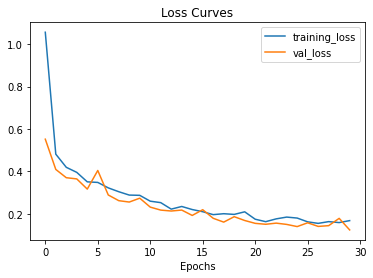

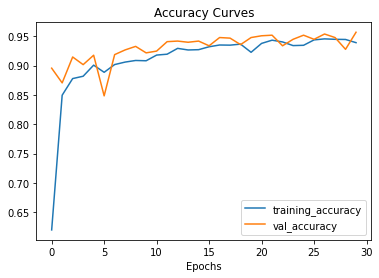

In [116]:
#model evaluation model 3
print("improve Model 2")
plot_loss_curves(history)

In [139]:
val_data = valid_data.next()

In [140]:
res = model.predict(val_data[0])
y_test = np.array(val_data[1]).argmax(axis=1)
res = res.argmax(axis=1)
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.97      1.00      0.98        32

    accuracy                           0.98        50
   macro avg       0.98      0.97      0.98        50
weighted avg       0.98      0.98      0.98        50



In [123]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(200, 200, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [126]:
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras import Input, Model

global_average_layer = GlobalAveragePooling2D()
layer_1 = Dense(15, activation='relu')
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(200, 200, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
x = layer_1(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# train model
history = model.fit(train_data,
                    epochs=30,
                    validation_data=valid_data)

Epoch 1/30
81/81 [==============================] - 74s 483ms/step - loss: 0.2191 - accuracy: 0.9132 - val_loss: 0.0837 - val_accuracy: 0.9659
Epoch 2/30
81/81 [==============================] - 36s 440ms/step - loss: 0.0782 - accuracy: 0.9701 - val_loss: 0.0644 - val_accuracy: 0.9769
Epoch 3/30
81/81 [==============================] - 36s 444ms/step - loss: 0.0481 - accuracy: 0.9799 - val_loss: 0.0190 - val_accuracy: 0.9950
Epoch 4/30
81/81 [==============================] - 35s 434ms/step - loss: 0.0374 - accuracy: 0.9881 - val_loss: 0.0172 - val_accuracy: 0.9940
Epoch 5/30
81/81 [==============================] - 35s 433ms/step - loss: 0.0312 - accuracy: 0.9886 - val_loss: 0.0788 - val_accuracy: 0.9709
Epoch 6/30
81/81 [==============================] - 35s 432ms/step - loss: 0.0259 - accuracy: 0.9903 - val_loss: 0.0143 - val_accuracy: 0.9950
Epoch 7/30
81/81 [==============================] - 35s 433ms/step - loss: 0.0230 - accuracy: 0.9910 - val_loss: 0.0095 - val_accuracy: 0.9970

improve Model 2


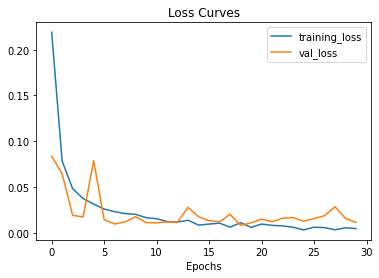

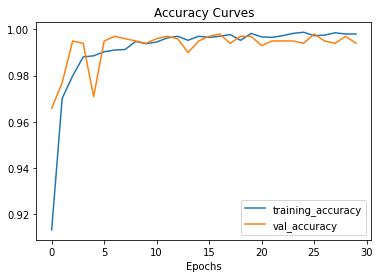

In [127]:
#model evaluation model 3
print("improve Model 2")
plot_loss_curves(history)

In [137]:
val_data = valid_data.next()

In [138]:
res = model.predict(val_data[0])
y_test = np.array(val_data[1]).argmax(axis=1)
res = res.argmax(axis=1)
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        29

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [ ]:
#model evaluation model 3
print("improve Model 2")
plot_loss_curves(history)

In [ ]:
from sklearn.metrics import classification_report
res = model.predict(valid_data)
y_test = valid_data.classes
res = res.argmax(axis=1)
print(classification_report(y_test, res))

In [ ]:
model.save('models/buah.h5')

Model Inference

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 2)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

In [ ]:
img3 = view_random_image(target_dir='dataset_buah/inference/',
                        target_class='freshoranges')

In [ ]:
model_pred = model.predict(inference_data)

model_pred1 = np.where(model_pred >= 0.7, 'Rotten', 'fresh')
model_pred1